# Edge Detection

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from skimage.transform import resize
from fastai.vision import *

In [2]:
path_lbl = '/storage/vocal_cords_and_rings_data/data/labels'
path_img = '/storage/vocal_cords_and_rings_data/data/images'

In [3]:
# cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/stage-2-big-0614-rn50.avi')
# #Advance 30 frames
# for i in range (0,1):
#     ret, frame = cap.read()

In [4]:
def cvt(img):
    return img[:, :, ::-1]

(141, 188, 3)


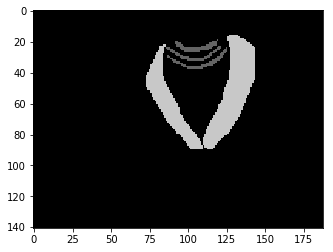

In [54]:
img_c = cv2.imread(str(get_image_files(path_img)[203]))
img = cv2.imread(str(get_image_files(path_lbl)[55]))
# img = resize(img, (500,500),anti_aliasing=True)

# fig=plt.figure(figsize=(8, 8))
# fig.add_subplot(1)

# plt.imshow(img*100)
# blur_img = cv2.blur(img, (3,3))
# plt.subplot(1,1)
plt.imshow(img*100)

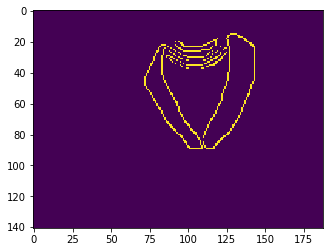

In [6]:
edges = cv2.Canny(img, 1,1)
plt.imshow(edges)

# Blob (Instance) Detection

In [222]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from scipy import ndimage

In [223]:
num_classes = 4 #everything_else, vocal_cords, tracheal_rings, bifurcation

In [224]:
def get_blobs(img, imshow=False):
    img2 = img_as_ubyte(np.array(img))
    print(img2.shape)

    #each channel in sep_classes contains a given class of labels. sep_blobs[i].shape is (img.width,img.height,num_classes)
    sep_classes = []
    for i in range (0,num_classes):
        sep_classes.append( np.array(img2 == i ).astype(np.uint) )
        
    print("stuff in [2] {}".format(np.unique(sep_classes[1])))

    blobs_labels = [measure.label(blobs, background=0)[:,:,0] for blobs in sep_classes]

    plt.figure(figsize=(9, 3.5))

    if imshow:
        for i in range(1,num_classes):
#             plt.axis('off')
            plt.subplot(130+i)
            plt.imshow(blobs_labels[i]*100, cmap='nipy_spectral')
            plt.title(str(i))

#         plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    return blobs_labels

In [6]:
# np.unique(labels)
labels = get_blobs(img,imshow=True)
one_ring = np.array(labels[1]==2)
plt.imshow(one_ring)
# ndimage.measurements.center_of_mass(one_ring)

NameError: name 'img' is not defined

Let's find blobs on a video

In [7]:
import sys
from fastai.vision import *
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from IPython.display import clear_output
################################################
learn = None
cap = None
out = None

path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()
################################################
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

codes = np.loadtxt(path_lbl/'../../codes.txt', dtype=str);
bs = 4

src = (SegmentationItemList.from_folder(path_img)
        .split_by_fname_file('../../valid.txt')
        .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = unet_learner(data, models.resnet101);
learn.load('stage-2-big-0614-rn101');
################################################
def crop_img(img,cropx,cropy):
    cropx=np.min(img.shape[:2])
    cropy=cropx
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return resize(img[starty:starty+cropy,startx:startx+cropx], (224,224),anti_aliasing=True) #dtype = float64
################################################
def mask_to_colour(mask,colour=[0,255,0]):
    output_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(np.uint8)
    green = [0,255,0]
    red = [255,0,0]
    blue = [0,0,255]
    other = [150,200,0]
    output_mask[mask==1]=red
    output_mask[mask==2]=green
    output_mask[mask==3]=blue
    return output_mask

#Swaps the r and b channels, for converting between PIL Image and Opencv BGR nparray
def red_blue_swap(img):
    return img[:, :, ::-1]
################################################

In [233]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
out = cv2.VideoWriter('/storage/vocal_cords_and_rings_data/nbs/output-blob-tests-2406.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30.0, (224,224))
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 45
#end time for annotation (in seconds)
end_time_s = 54
mask_timeline = []
clean_timeline = []
clean_flattened_timeline = []
###ENDOF PARAMS###

Cap fps: 29.97002997002997


In [234]:
#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
    
clear_output()
print ("Starting!")
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    print(ctr)
    
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break

            
    #Convert from OpenCV image to pytorch tensor, to Image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #frame_rgb is uint8
    
    t = PIL.Image.fromarray(frame_rgb)
    t = pil2tensor(t.convert("RGB"), np.float32).div_(255)
    t = Image(t)
    
    #Predict
    prediction = learn.predict(t)
    p = prediction[1] #prediction data
    p1 = np.array(p)
    p1.astype('uint8')

    p3 = p1
    p3 = p3.squeeze()
    
    p4 = np.expand_dims(p3, axis=2)
    p4 = p4.astype('uint8')
    
    mask = np.copy(p4)
    mask=mask.squeeze()

    mask_d = mask_to_colour(mask)
    mask_d = img_as_float(mask_d)
    
    mask_timeline.append(mask)
#     plt.imshow(mask_d)
#     plt.show()
    
    ########################## NEW STUFF #################################
    img = mask
    img = img.astype(np.float32)
    # img = cv2.resize(img,(240,190))

    #img.shape[0]/2, img.shape[1]/2
    #360,350


    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(img,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
    polar_image = polar_image.astype(np.uint8)

    # plot_many([_,mask_timeline[71],polar_image])
#     plot_many([_,img,polar_image])
    
    e = cv2.erode(polar_image,np.ones((11,1)))
    e = cv2.erode(e,np.ones((2,2)))
    
    clean_flattened_timeline.append(e)
    linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    clean_timeline.append(linear_image)
#     plt.imshow(linear_image)
#     plt.show()
    
#     cr=crop_img(frame,224,224) #cr is float64
    
#     #Save the overlaid frame
#     ov=overlay_mask(cr, mask_d)
    
#     # Write uint8 version of ov to output video
#     out.write(img_as_ubyte(ov))
    
cap.release()
out.release()
print ("End!")

Starting!
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548


In [235]:
len(clean_flattened_timeline)

270

# Tracking

(224, 224)

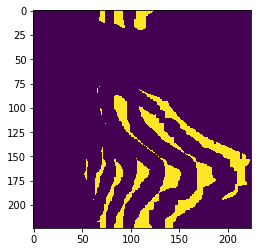

In [250]:
plt.imshow(clean_flattened_timeline[71]==1)
clean_flattened_timeline[71].shape

0.0
411.5
294.5
37.0
0.0
653.5
0.0
0.0
801.5
103.5
1.0
0.0
0.0
2.0
420.5
358.5
1191.0
0.0
0.0
214.0
135.0
49.0
5779.5
Boxes: 4


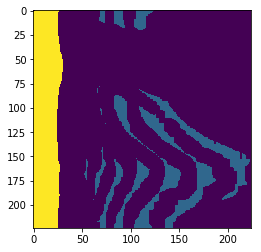

Boxes: 4


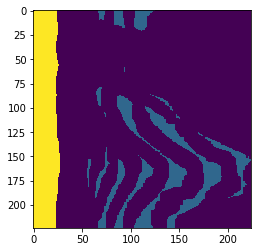

Boxes: 4


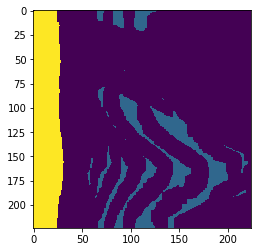

Boxes: 4


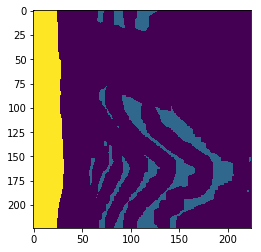

Boxes: 4


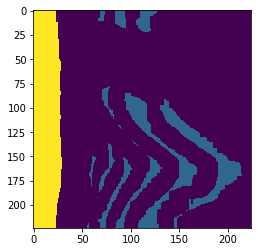

Boxes: 4


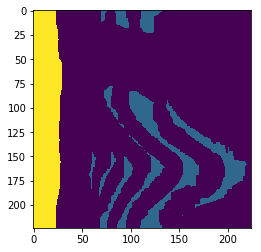

Boxes: 4


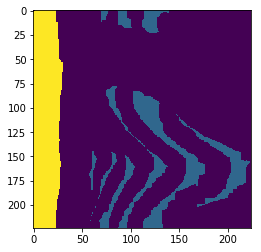

Boxes: 4


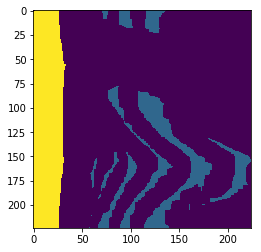

Boxes: 4


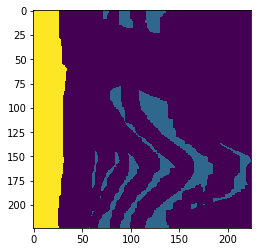

Boxes: 4


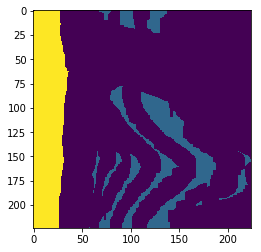

Boxes: 4


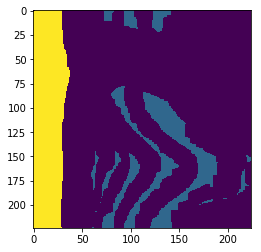

Boxes: 4


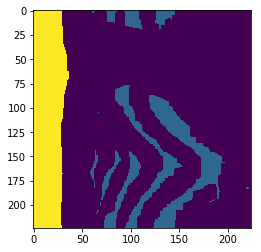

Boxes: 4


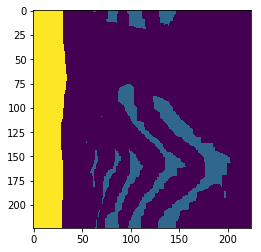

Boxes: 4


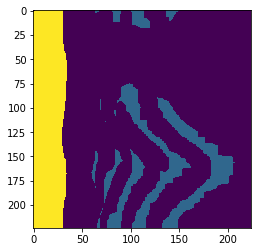

Boxes: 4


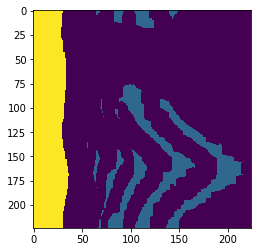

Boxes: 4


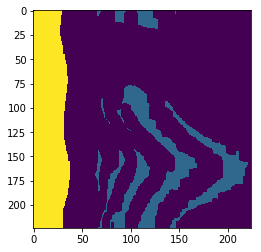

Boxes: 4


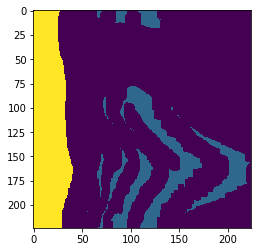

Boxes: 4


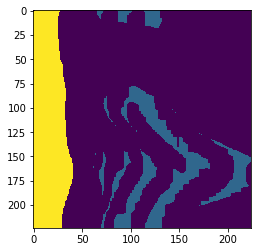

Boxes: 4


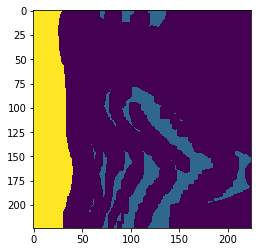

Boxes: 4


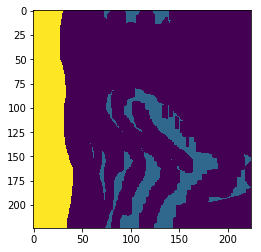

Boxes: 4


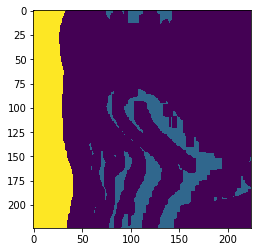

Boxes: 4


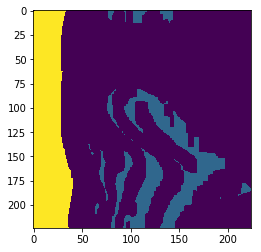

Boxes: 4


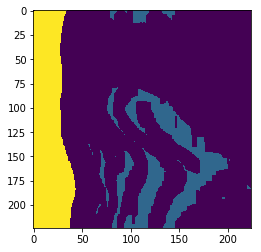

Boxes: 4


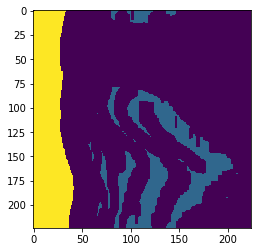

Boxes: 4


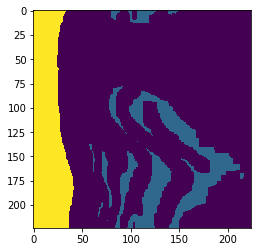

Boxes: 4


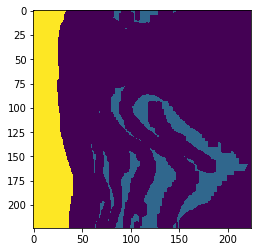

Boxes: 4


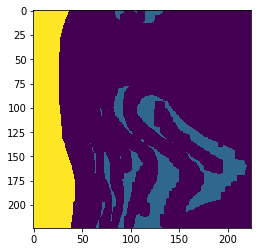

Boxes: 4


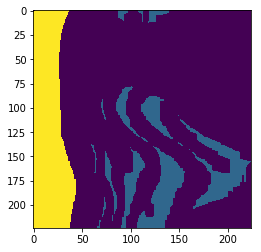

Boxes: 4


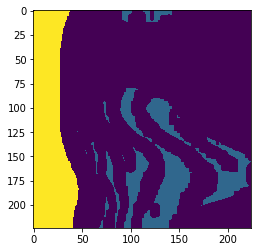

Boxes: 4


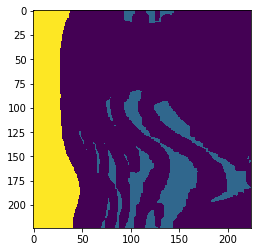

Boxes: 4


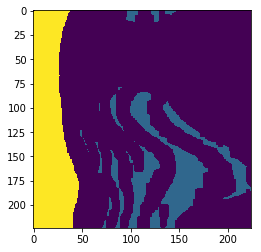

Boxes: 4


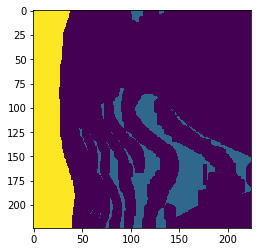

Boxes: 4


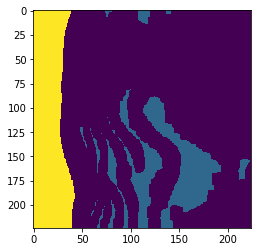

Boxes: 4


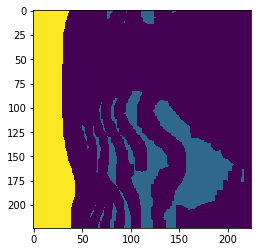

Boxes: 4


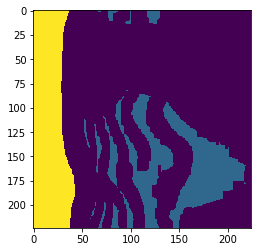

Boxes: 4


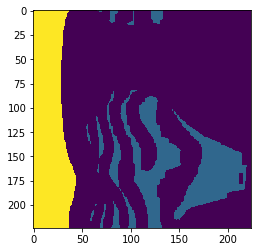

Boxes: 4


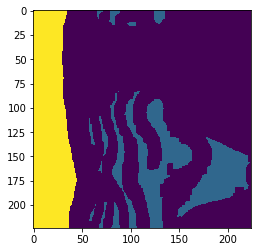

Boxes: 4


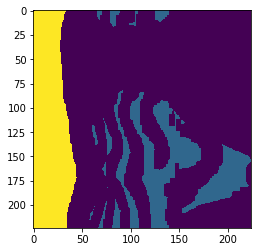

Boxes: 4


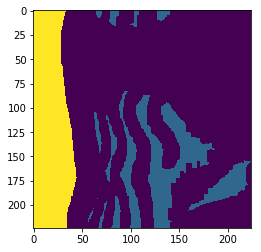

Boxes: 4


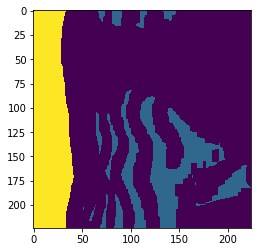

Boxes: 4


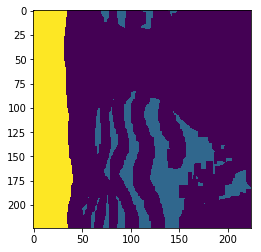

Boxes: 4


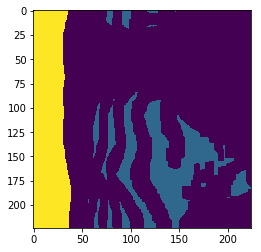

Boxes: 4


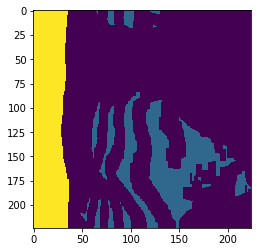

Boxes: 4


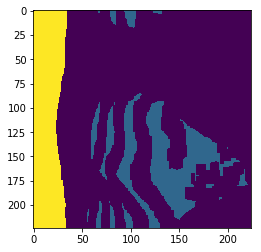

Boxes: 4


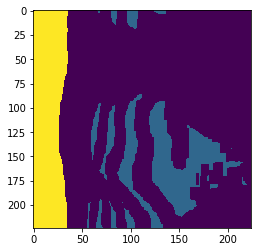

Boxes: 4


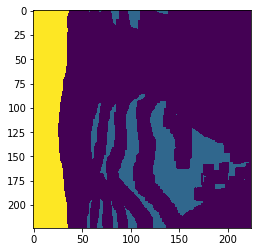

Boxes: 4


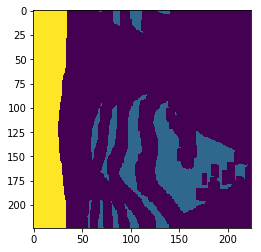

Boxes: 4


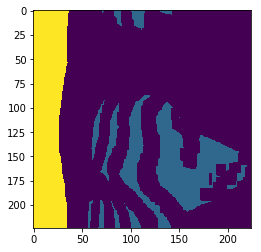

Boxes: 4


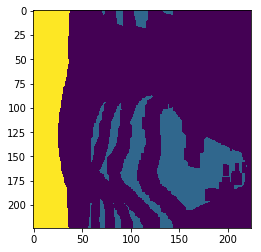

Boxes: 4


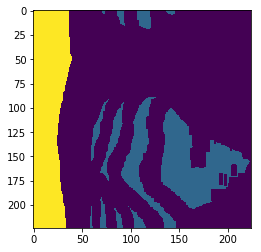

Boxes: 4


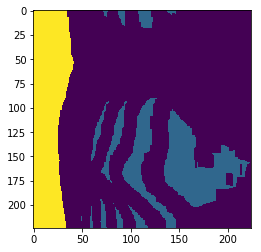

Boxes: 4


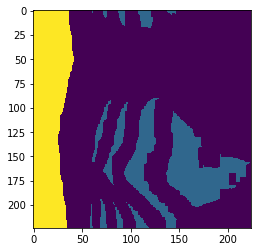

Boxes: 4


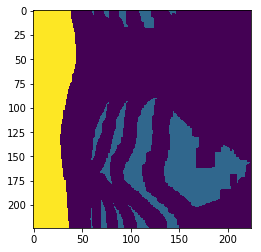

Boxes: 4


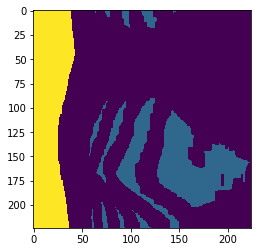

Boxes: 4


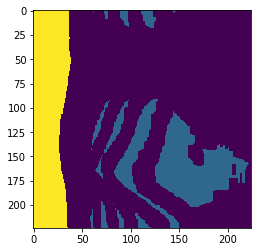

Boxes: 4


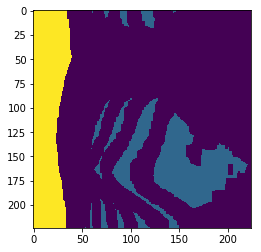

Boxes: 4


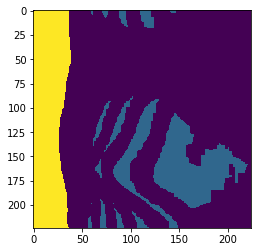

Boxes: 4


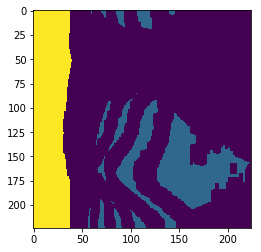

Boxes: 4


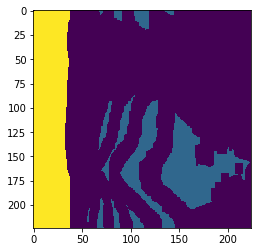

Boxes: 4


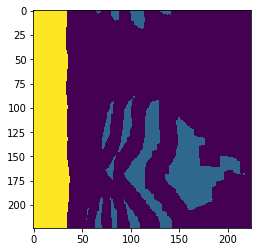

Boxes: 4


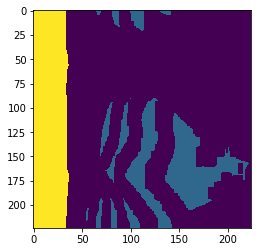

Boxes: 4


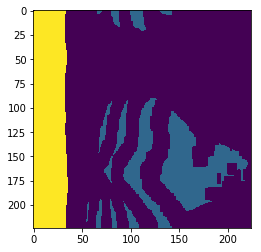

Boxes: 4


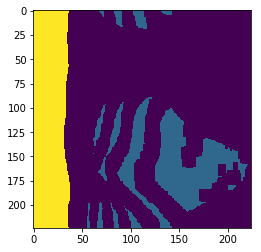

Boxes: 4


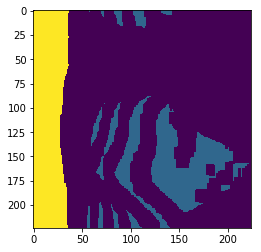

Boxes: 4


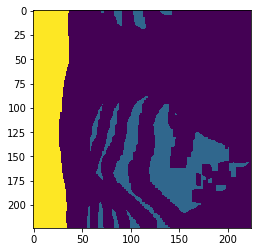

Boxes: 4


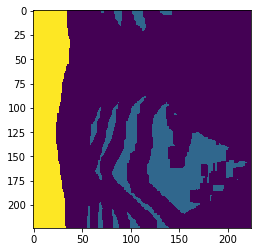

Boxes: 4


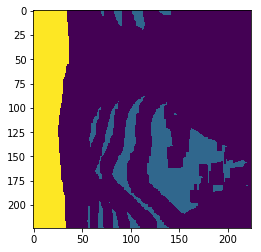

Boxes: 4


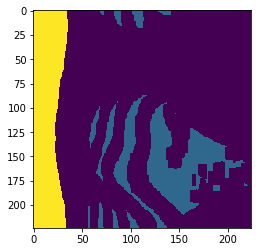

Boxes: 4


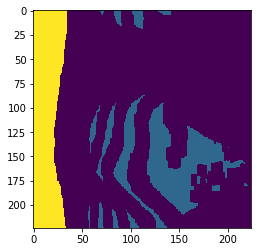

Boxes: 4


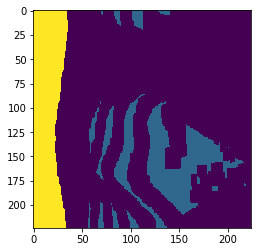

Boxes: 4


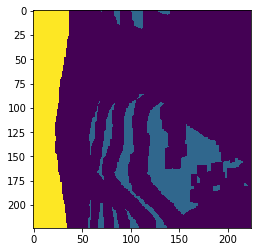

Boxes: 4


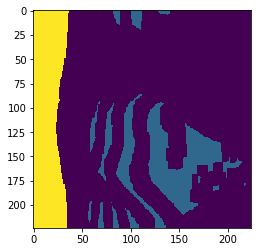

Boxes: 4


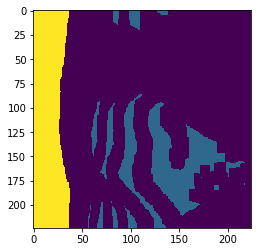

Boxes: 4


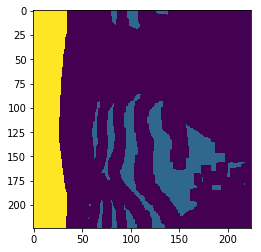

Boxes: 4


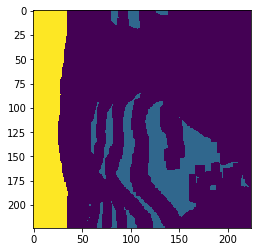

Boxes: 4


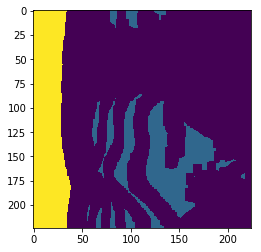

Boxes: 4


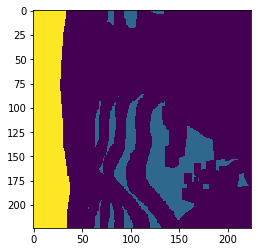

Boxes: 4


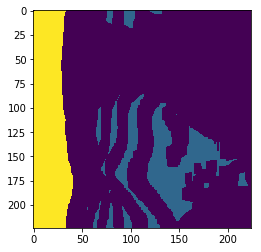

Boxes: 4


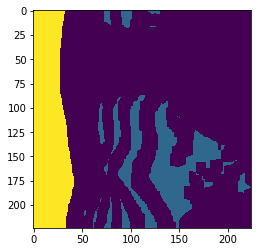

Boxes: 4


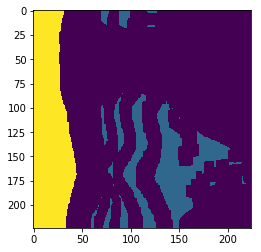

Boxes: 4


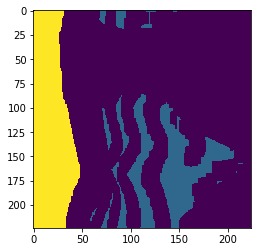

Boxes: 4


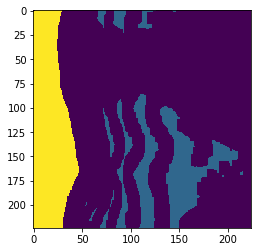

Boxes: 4


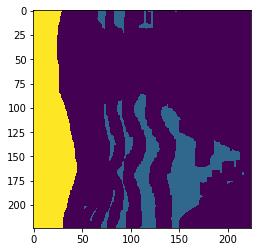

Boxes: 4


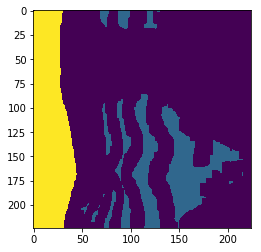

Boxes: 4


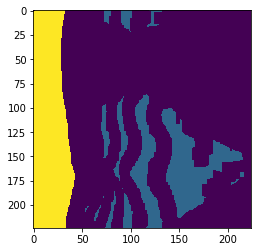

Boxes: 4


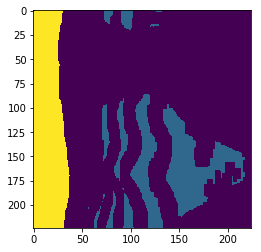

Boxes: 4


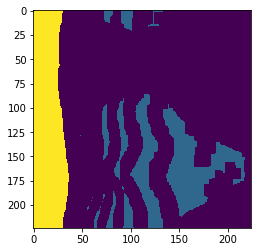

Boxes: 4


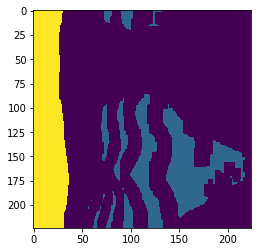

Boxes: 4


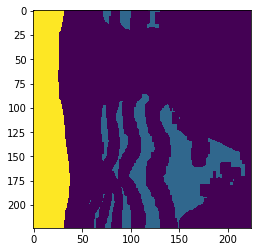

Boxes: 4


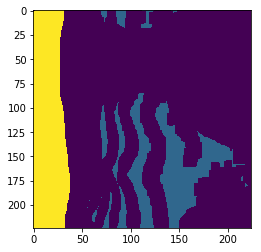

Boxes: 4


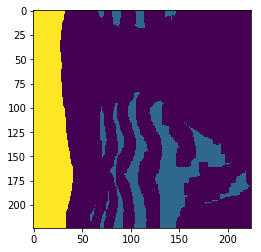

Boxes: 4


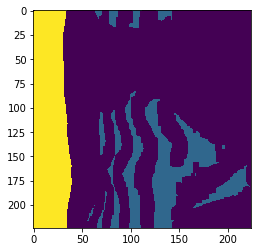

Boxes: 4


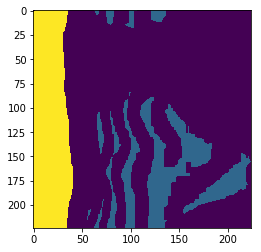

Boxes: 4


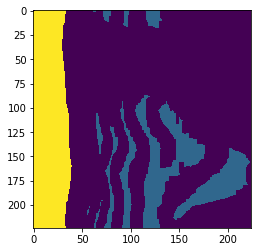

Boxes: 4


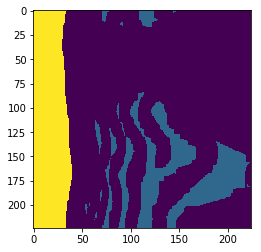

Boxes: 4


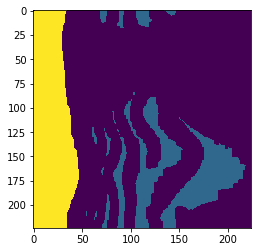

Boxes: 4


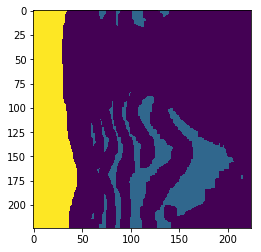

Boxes: 4


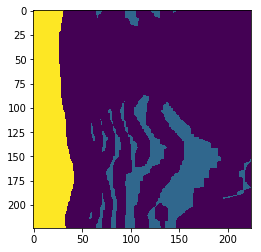

Boxes: 4


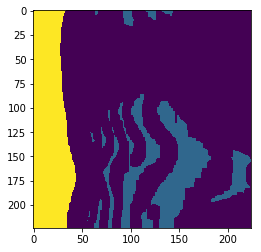

Boxes: 4


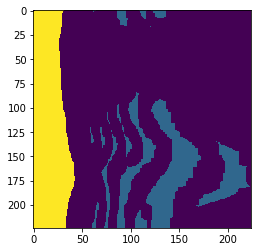

Boxes: 4


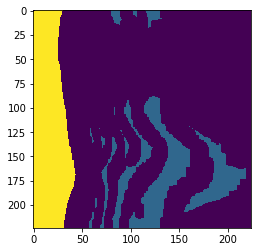

Boxes: 4


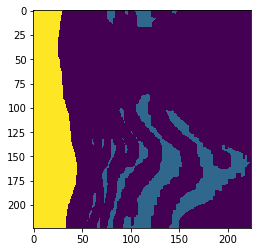

Boxes: 4


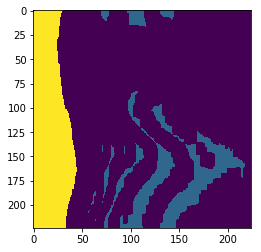

Boxes: 4


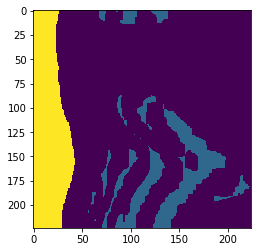

Boxes: 4


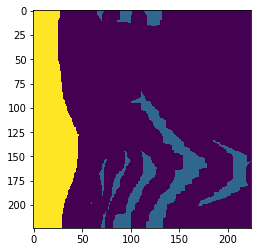

Boxes: 4


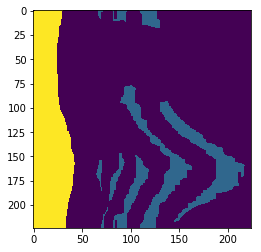

Boxes: 4


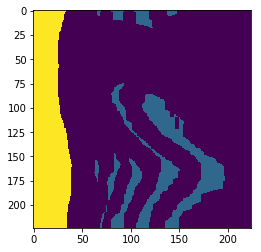

Boxes: 4


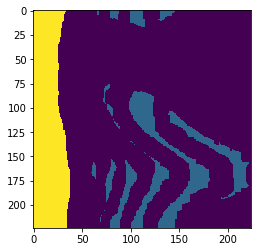

Boxes: 4


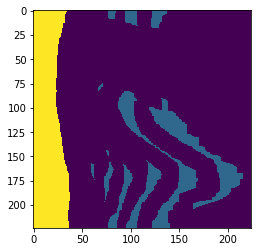

Boxes: 4


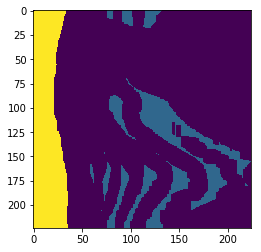

Boxes: 4


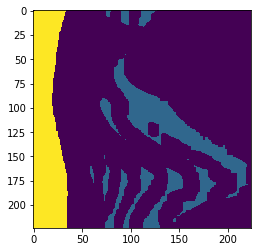

Boxes: 4


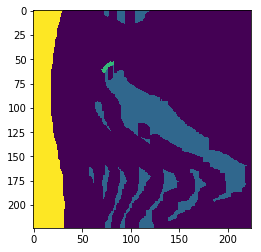

Boxes: 4


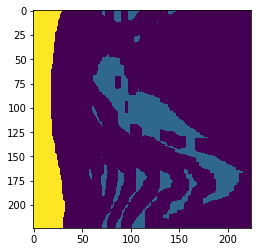

Boxes: 4


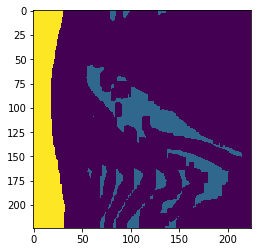

Boxes: 4


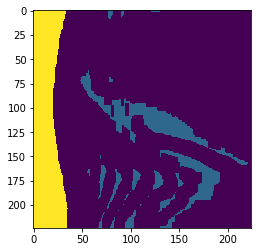

Boxes: 4


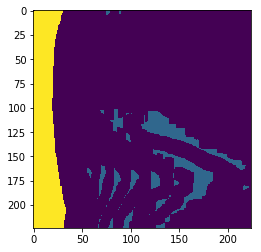

Boxes: 4


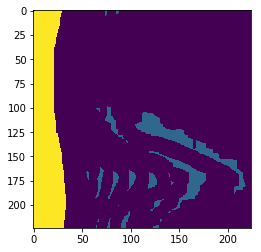

Boxes: 4


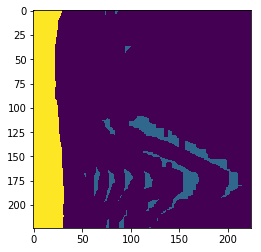

Boxes: 4


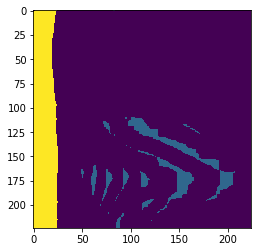

Boxes: 4


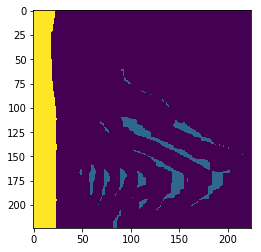

Boxes: 4


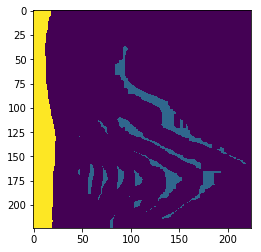

Boxes: 4


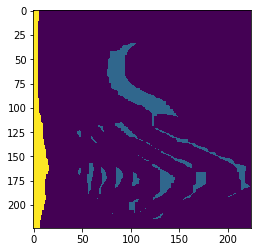

Boxes: 4


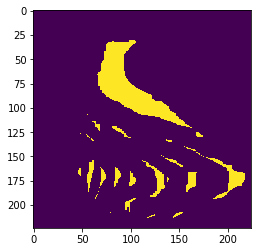

Boxes: 4


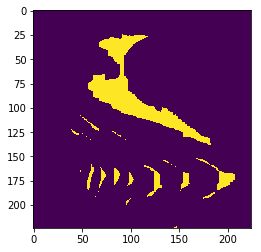

Boxes: 4


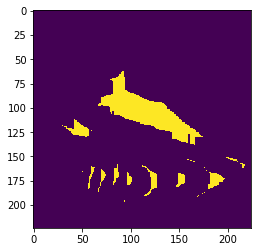

Boxes: 4


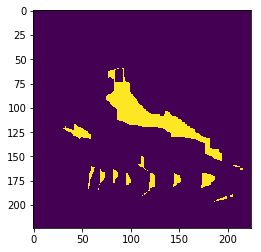

Boxes: 4


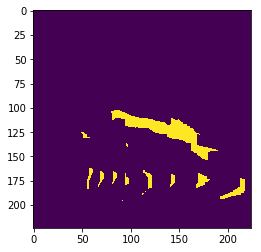

Boxes: 4


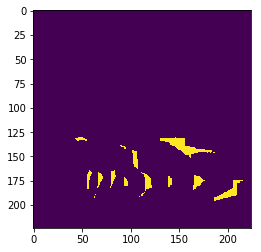

Boxes: 4


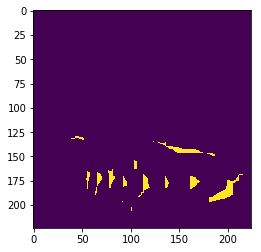

Boxes: 4


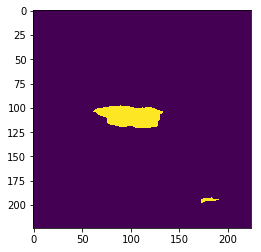

Boxes: 4


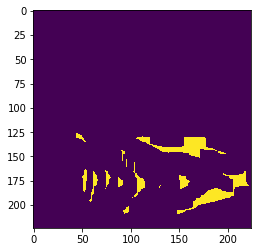

Boxes: 4


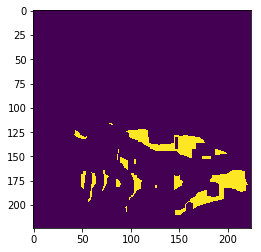

Boxes: 4


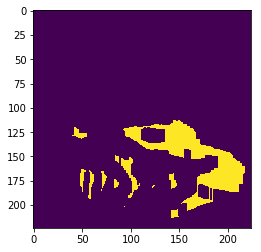

Boxes: 4


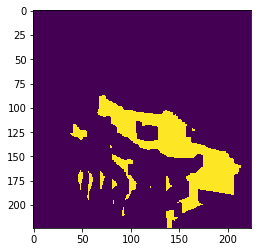

Boxes: 4


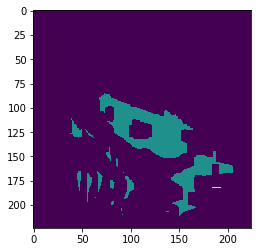

Boxes: 4


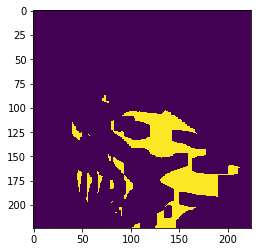

Boxes: 4


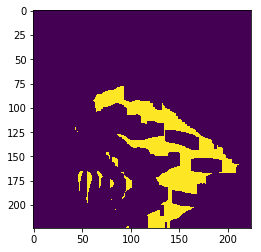

Boxes: 4


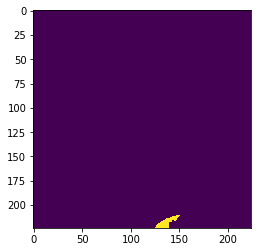

Boxes: 4


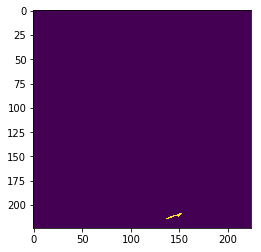

Boxes: 4


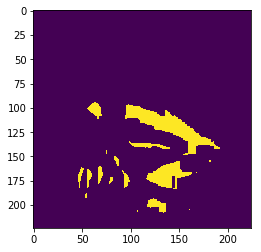

Boxes: 4


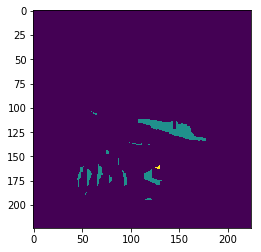

Boxes: 4


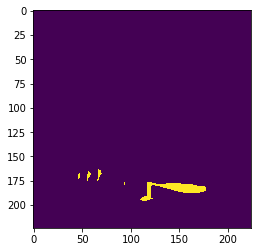

Boxes: 4


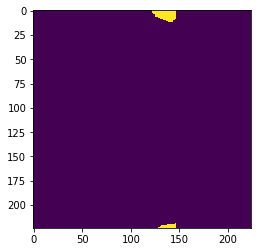

Boxes: 4


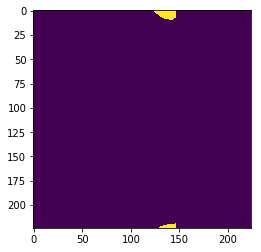

Boxes: 4


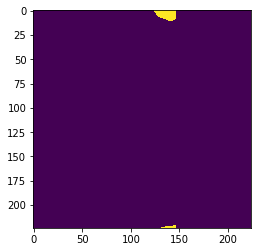

Boxes: 4


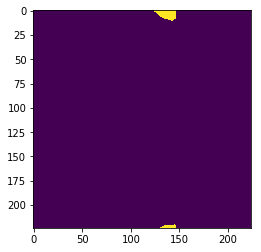

Boxes: 4


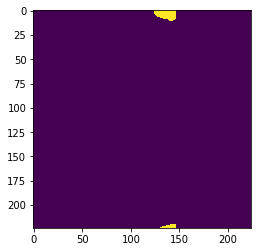

Boxes: 4


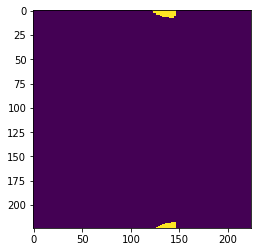

Boxes: 4


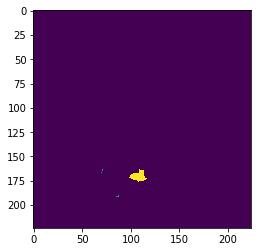

Boxes: 4


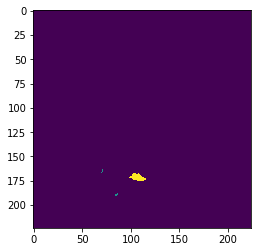

Boxes: 4


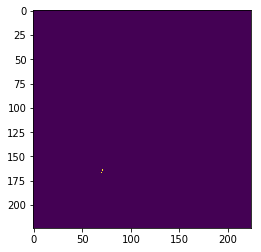

Boxes: 4


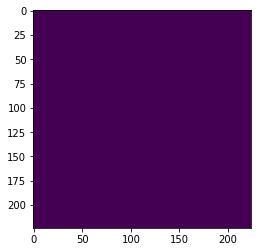

Boxes: 4


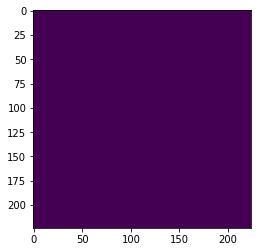

Boxes: 4


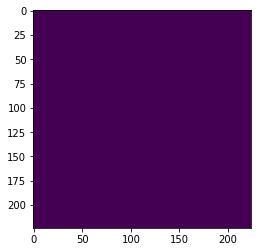

Boxes: 4


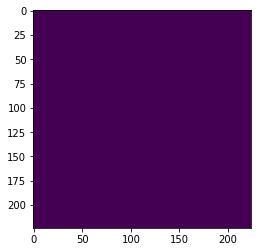

Boxes: 4


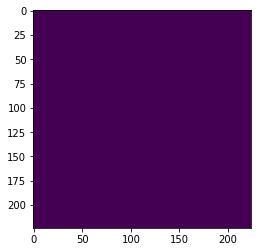

Boxes: 4


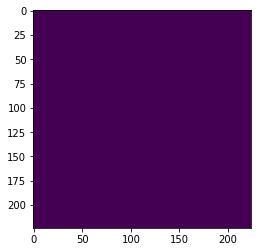

Boxes: 4


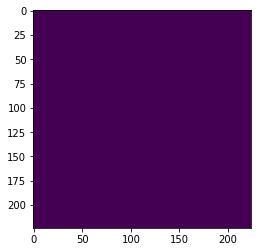

Boxes: 4


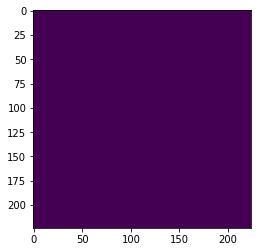

Boxes: 4


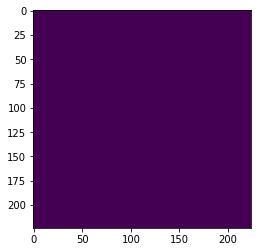

Boxes: 4


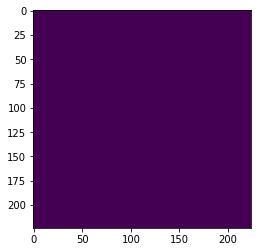

Boxes: 4


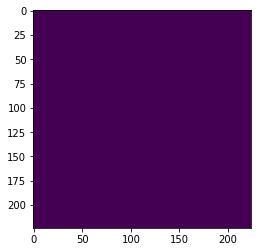

Boxes: 4


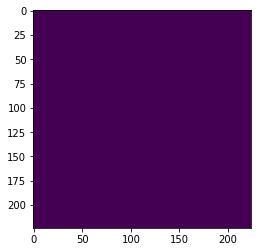

Boxes: 4


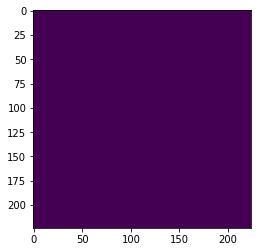

Boxes: 4


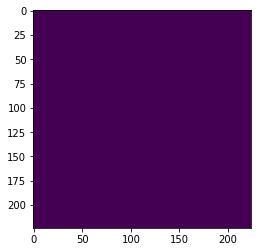

Boxes: 4


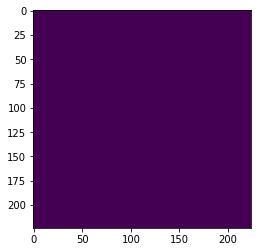

Boxes: 4


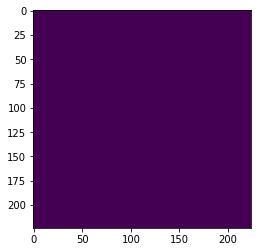

Boxes: 4


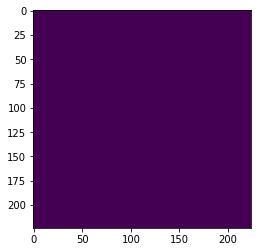

Boxes: 4


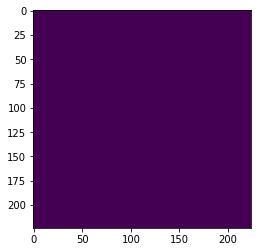

Boxes: 4


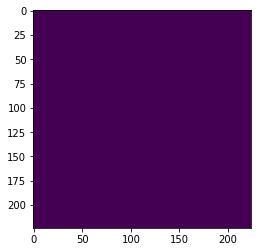

Boxes: 4


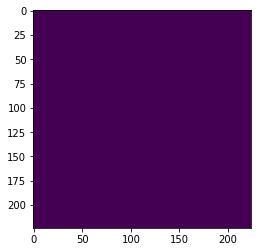

Boxes: 4


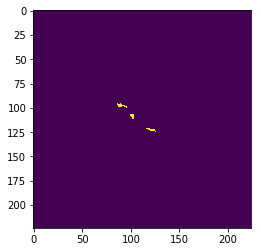

Boxes: 4


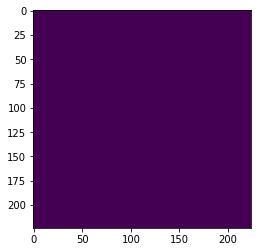

Boxes: 4


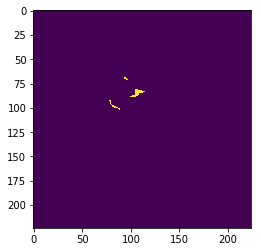

Boxes: 4


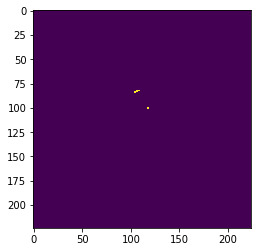

Boxes: 4


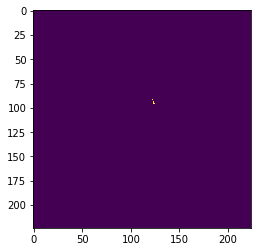

Boxes: 4


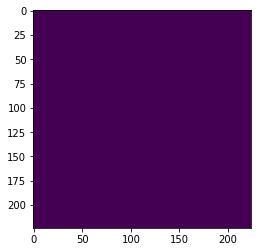

Boxes: 4


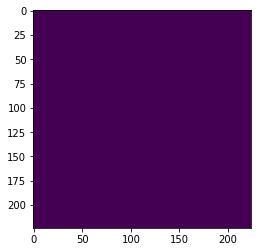

Boxes: 4


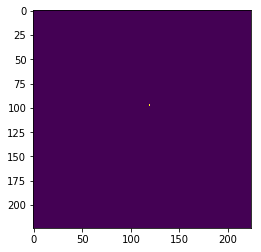

Boxes: 4


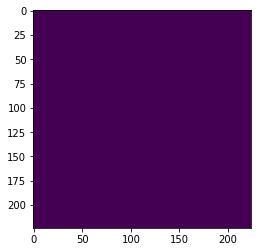

Boxes: 4


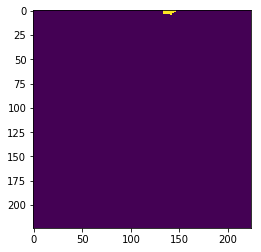

Boxes: 4


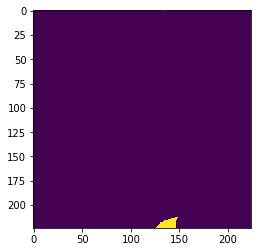

Boxes: 4


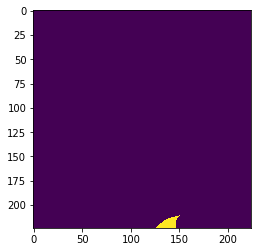

Boxes: 4


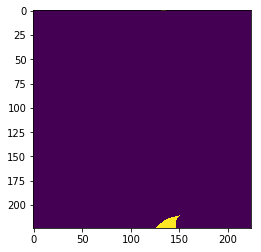

Boxes: 4


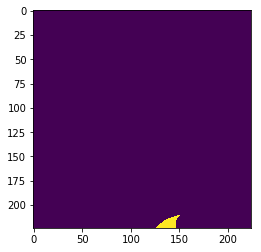

Boxes: 4


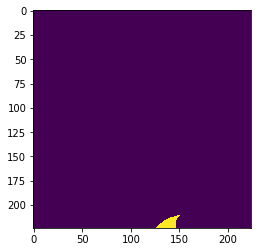

Boxes: 4


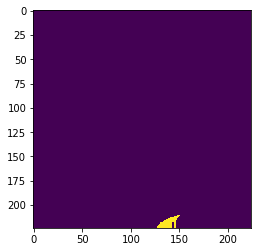

Boxes: 4


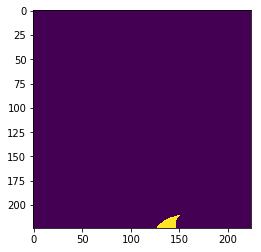

Boxes: 4


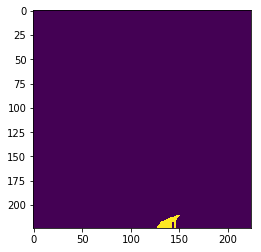

Boxes: 4


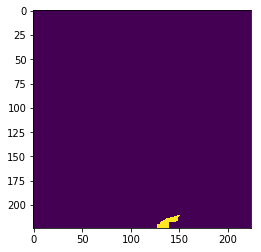

Boxes: 4


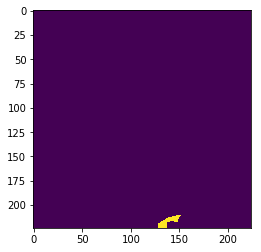

Boxes: 4


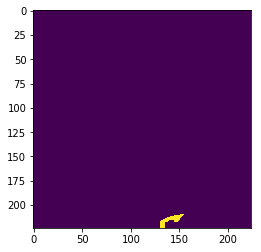

Boxes: 4


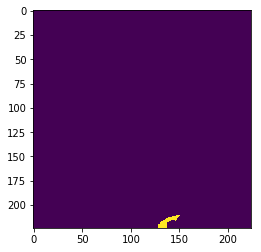

Boxes: 4


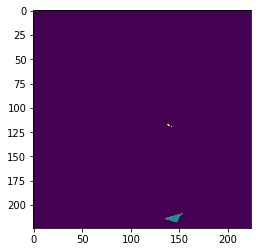

Boxes: 4


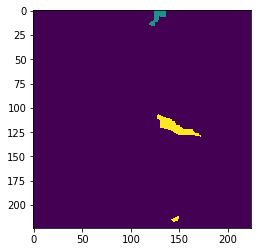

Boxes: 4


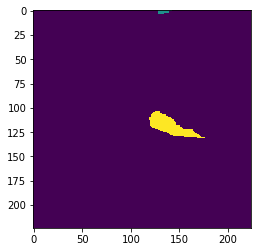

Boxes: 4


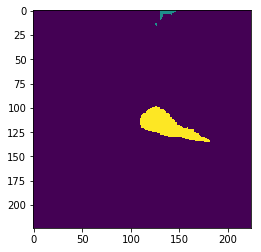

Boxes: 4


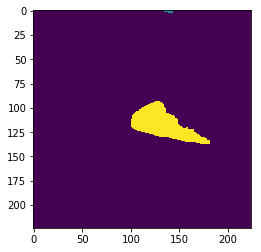

Boxes: 4


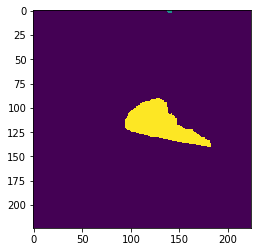

In [267]:
tracker = cv2.MultiTracker_create()

colors = [] 
colors.append((0,255,0))
 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
# while True:
#   # draw bounding boxes over objects
#   # selectROI's default behaviour is to draw box starting from the center
#   # when fromCenter is set to false, you can draw box starting from top left corner
#   bbox = cv2.selectROI('MultiTracker', frame)
#   bboxes.append(bbox)
#   colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
#   print("Press q to quit selecting boxes and start tracking")
#   print("Press any other key to select next object")
#   k = cv2.waitKey(0) & 0xFF
#   if (k == 113):  # q is pressed
#     break

bboxes = []
im = np.zeros((224,224,3), np.uint8)

_, contours, _ = cv2.findContours(clean_flattened_timeline[71]*100, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    rect = cv2.boundingRect(c)
#     if rect[2] * rect[3] < 100: continue
    print (cv2.contourArea(c))
    x,y,w,h = rect
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
    bboxes.append(rect)
    
###Remove this after
bboxes = bboxes[5]

plt.imshow(im)
 
# Create MultiTracker object
# multiTracker = cv2.MultiTracker_create()
 
# Initialize MultiTracker 
# for bbox in bboxes:
#     multiTracker.add(cv2.TrackerCSRT_create(), clean_flattened_timeline[71], bbox)
tracker = cv2.TrackerCSRT_create()

for frame in clean_flattened_timeline[71:]:
   
    # get updated location of objects in subsequent frames
    success, boxes = tracker.update(frame)
    print("Boxes: {}".format(len(boxes)))
    
    output_frame = frame.copy()
    # draw tracked objects
#     for i, newbox in enumerate(boxes):
    newbox=boxes
    p1 = (int(newbox[0]), int(newbox[1]))
    p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
    
    cv2.rectangle(output_frame, p1, p2, colors[i], 2, 1)
 
    # show frame
    plt.imshow(output_frame)
    plt.show()
   
 
    # quit on ESC button

<function matplotlib.pyplot.show(*args, **kw)>

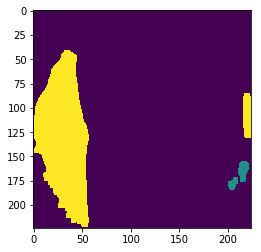

In [11]:

mask_c = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR))
# plt.imshow(mask_c*100.0)

mask_dilate = np.zeros_like(mask)
mask_dilate = cv2.erode(mask,np.ones((3,3)))
mask_dilate = cv2.dilate(mask_dilate,np.ones((5,5)))
plt.imshow(mask_dilate)
plt.show

# labels = get_blobs(mask_c,imshow=True)
# one_ring = np.array(labels[1]==10)
# plt.imshow(one_ring)
# ndimage.measurements.center_of_mass(one_ring)

In [12]:
def plot_many(images):
    plt.figure(figsize=(9, 3.5))

    
    for i in range(1,len(images)):
#             plt.axis('off')
        plt.subplot(130+i)
        plt.imshow(images[i], cmap='nipy_spectral')
        plt.title(str(i))

#         plt.axis('off')
    plt.tight_layout()
    plt.show()


[0 1 3]
(224, 224, 3)
stuff in [2] [0 1]


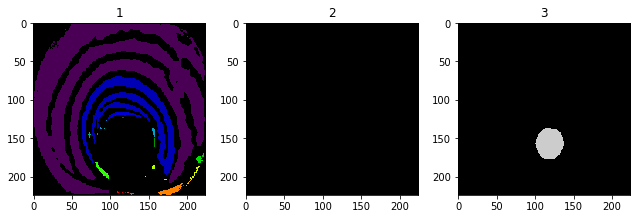

In [168]:
img = cv2.cvtColor(mask_timeline[71],cv2.COLOR_GRAY2BGR)
print(np.unique(img))
labels = get_blobs(img,imshow=True)

[0 1]
[[0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 ...
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]]
(118, 156)


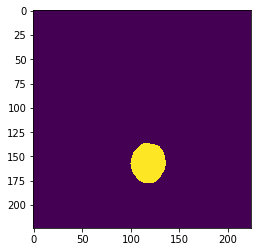

In [179]:
plt.imshow(labels[3])

thresh = labels[3]
 
print(np.unique(thresh))
thresh = img_as_uint(thresh*100)
print(thresh)
# convert the grayscale image to binary image
# ret,thresh = cv2.threshold(gray_image,127,255,0)
 
# calculate moments of binary image
M = cv2.moments(thresh)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print((cX,cY))

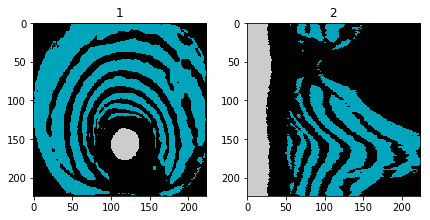

In [192]:
# targ = cv2.imread("/storage/vocal_cords_and_rings_data/data/target3.PNG")
# plt.imshow(targ)

############################
# img = targ
img = mask_timeline[71]
img = img.astype(np.float32)
# img = cv2.resize(img,(240,190))

#img.shape[0]/2, img.shape[1]/2
#360,350


value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
polar_image = cv2.linearPolar(img,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
polar_image = polar_image.astype(np.uint8)

# plot_many([_,mask_timeline[71],polar_image])
plot_many([_,img,polar_image])

[0 1 3]


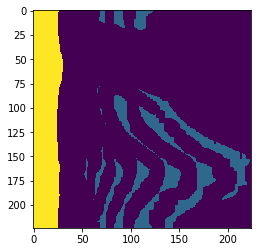

In [213]:
e = cv2.erode(polar_image,np.ones((11,1)))
e = cv2.erode(e,np.ones((2,2)))

plt.imshow(e)
print(np.unique(e))

[0 1 3]
1


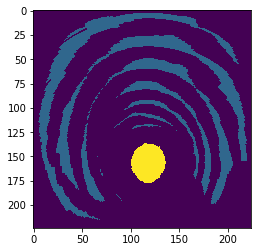

In [214]:
linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
plt.imshow(linear_image)
print(np.unique(linear_image))
print(linear_image[cX,cY])

[0 1 3]
(224, 224, 3)
stuff in [2] [0 1]


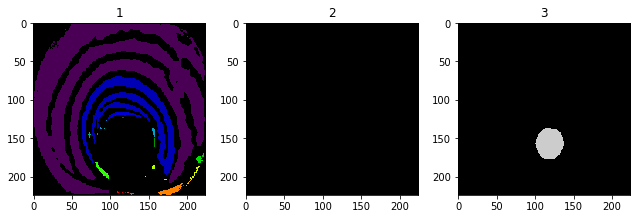

[[1 1 1 1 ... 1 1 1 1]
 [1 1 1 1 ... 1 1 1 1]
 [1 1 1 1 ... 1 1 1 1]
 [1 1 1 1 ... 1 1 1 1]
 ...
 [4 4 4 4 ... 4 4 4 4]
 [4 4 4 4 ... 4 4 4 4]
 [4 4 4 4 ... 4 4 4 4]
 [4 4 4 4 ... 4 4 4 4]]
[0 1 3]
(224, 224, 3)
stuff in [2] [0 1]


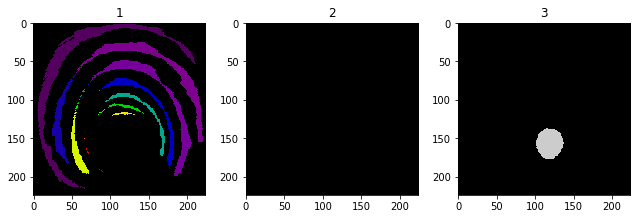

4


In [221]:
img = cv2.cvtColor(mask_timeline[71],cv2.COLOR_GRAY2BGR)
print(np.unique(img))
labels = get_blobs(img,imshow=True)

img = cv2.cvtColor(linear_image,cv2.COLOR_GRAY2BGR)
print(np.unique(img))
labels = get_blobs(img,imshow=True)

In [118]:
# print(cv2.cvtColor(labels[1],cv2.COLOR_GRAY2BGR).shape)
from imutils import perspective
from imutils import contours
import imutils

# edged = cv2.Canny(img*100, 50, 100)
# edged = cv2.dilate(edged, None, iterations=1)
# edged = cv2.erode(edged, None, iterations=1)

cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
 
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)


5


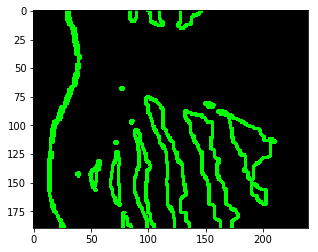

In [119]:
large_cnts=[]
for c in cnts:
    if cv2.contourArea(c) > 30:
        large_cnts.append(c)
print(len(large_cnts))
orig = np.zeros_like(img)
cv2.drawContours(orig, [l for l in cnts], -1, (0, 255, 0), 2)
plt.imshow(orig)
# plot_many([cv2.drawContours(orig, l, -1, (0, 255, 0), 2) for l in cnts][:2])